## GANITE(Tensorflow): Train and Evaluation

This notebook presents the solution for training and evaluating GANITE(Tensoflow version).

The implementation of GANITE is adapted in the local `ite` library.

First, make sure that all the depends are installed.
```
pip install -r requirements.txt
pip install .
```

### Setup

First, we import all the dependencies necessary for the task.

In [1]:
# Double check that we are using the correct interpreter.
import sys
print(sys.executable)

# Disable TF logging
import os 
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
    
# Import
import ite.algs.ganite.model as alg
import ite.datasets as ds
import ite.utils.tensorflow as utils

from matplotlib import pyplot as plt
import pandas as pd
import tensorflow.compat.v1 as tf

/home/bcebere/anaconda3/envs/cambridge/bin/python
Instructions for updating:
non-resource variables are not supported in the long term


### Load the Dataset



In [2]:
train_ratio = 0.8
 
dataloader = ds.load("twins", train_ratio)
[Train_X, Train_T, Train_Y, Opt_Train_Y, Test_X, Test_Y] = dataloader


pd.DataFrame(data=Train_X[:5])

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,5.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,40.0,1.0,27.0,26.0,10.0,1.0,1.0,0.0,0.0,3.0
1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,7.0,1.0,23.0,31.0,12.0,1.0,1.0,2.0,15.0,1.0
2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,14.0,1.0,29.0,15.0,9.0,2.0,1.0,5.0,4.0,2.0
3,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,20.0,1.0,25.0,14.0,9.0,2.0,1.0,3.0,3.0,2.0
4,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,...,45.0,1.0,31.0,34.0,12.0,1.0,1.0,1.0,13.0,1.0


### Load the model

In [3]:
dim = len(Train_X[0])
dim_hidden = 8
dim_outcome = Test_Y.shape[1]
 
model = alg.Ganite(
    dim, # number of 
    dim_outcome, # size of the output
    dim_hidden=dim_hidden, # (optional) size of the hidden layers
    num_iterations=10000, # number of training iterations
    alpha=2, # alpha hyperparameter, used for the Generator block loss
    beta=2, # beta hyperparameter, used for the ITE block loss
    minibatch_size=128, # data batch size
    num_discr_iterations=10, # number of iterations executed by the discriminator.
    depth=1, # (optional) the depth of the linear layers in each internal model
)

assert model is not None

### Train

In [4]:
metrics = model.train(*dataloader)

100%|██████████| 10000/10000 [00:07<00:00, 1327.70it/s]


### Plot train metrics

Counterfactual Block:
 - Discriminator loss: 0.708 +/- 0.042
 - Generator loss: -1.402 +/- 0.071
ITE Block:
 - Loss: 0.262 +/- 0.056
ITE Block in-sample metrics:
 - sqrt_PEHE: 0.303 +/- 0.018
 - ATE: 0.016 +/- 0.026
ITE Block out-sample metrics:
 - sqrt_PEHE: 0.296 +/- 0.018
 - ATE: 0.017 +/- 0.027


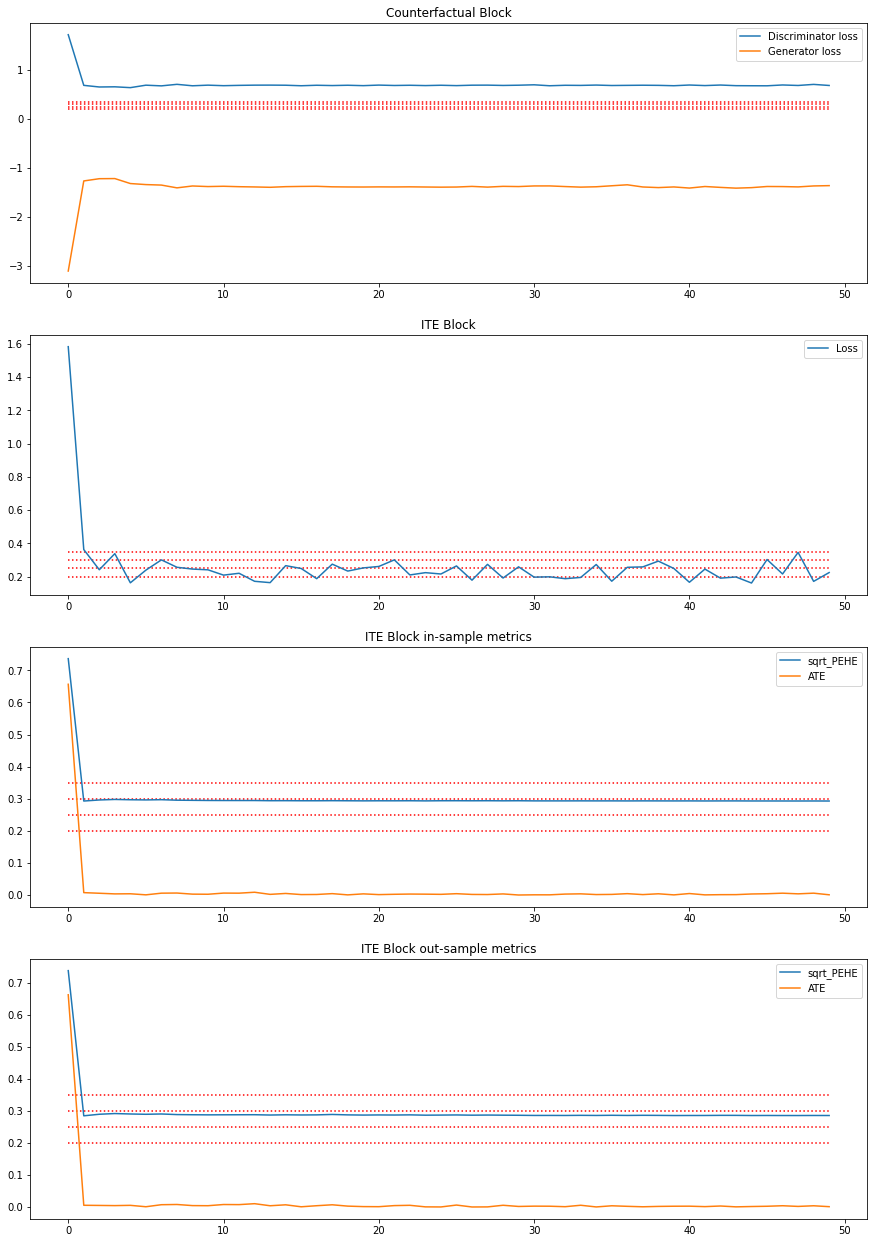

In [5]:
metrics.plot(plt, thresholds = [0.2, 0.25, 0.3, 0.35])

metrics.print()

### Predict

You can use run inferences on the model and evaluate the output.

In [6]:
sess = tf.InteractiveSession()

hat_y = model.predict(Test_X)

utils.sqrt_PEHE(hat_y, Test_Y).eval()

0.2854642804261596

### Test
Will can run inferences and get metrics directly

In [7]:
test_metrics = model.test(Test_X, Test_Y)

test_metrics.print()

sqrt_PHE = 0.285
ATE = 0.004
Top 5 worst mistakes(indices) = [ 415 1227 1931   17 1377]
